# Clustering 

In [1]:
# Load Libraries
import pandas as pd
import re
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import itertools
import numpy as np
import seaborn as sns

# machine learning
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#from xgboost import XGBRegressor

#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Load the data

df_movies = pd.read_csv("classificationPreprocessingGeneral.csv")
print("Length after import: " + str(len(df_movies)))
df_movies = df_movies.fillna(0)
print(df_movies.head(5))
df_movies.columns

Length after import: 43872
     budget     id  runtime  Documentary  Foreign  Action  Horror  War  \
0  30000000    862     81.0          0.0      0.0     0.0     0.0  0.0   
1  65000000   8844    104.0          0.0      0.0     0.0     0.0  0.0   
2         0  15602    101.0          0.0      0.0     0.0     0.0  0.0   
3  16000000  31357    127.0          0.0      0.0     0.0     0.0  0.0   
4         0  11862    106.0          0.0      0.0     0.0     0.0  0.0   

   Romance  Adventure  ...  actor_Donald Sutherland  actor_Robert De Niro  \
0      0.0        0.0  ...                        0                     0   
1      0.0        1.0  ...                        0                     0   
2      1.0        0.0  ...                        0                     0   
3      1.0        0.0  ...                        0                     0   
4      0.0        0.0  ...                        0                     0   

   actor_Samuel L. Jackson  actor_Jackie Chan  actor_Michael Cain

Index(['budget', 'id', 'runtime', 'Documentary', 'Foreign', 'Action', 'Horror',
       'War', 'Romance', 'Adventure', 'Thriller', 'History', 'Drama', 'Family',
       'Comedy', 'TV Movie', 'Crime', 'Western', 'Mystery', 'Fantasy',
       'Animation', 'Music', 'Science Fiction', 'part_of_collection', '+18',
       'hasHomepage', '18+', 'spokenLanguages', 'movieId', 'imdbId',
       'director', 'actors', 'pcomp_Orion Pictures', 'pcomp_New Line Cinema',
       'pcomp_Gaumont', 'pcomp_Twentieth Century Fox Film Corporation',
       'pcomp_Walt Disney Productions', 'pcomp_Paramount Pictures',
       'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
       'pcomp_StudioCanal', 'pcomp_Columbia Pictures Corporation',
       'pcomp_Regency Enterprises', 'pcomp_Touchstone Pictures',
       'pcomp_Mosfilm', 'pcomp_RKO Radio Pictures', 'pcomp_Miramax Films',
       'pcomp_TriStar Pictures', 'pcomp_Columbia Pictures',
       'pcomp_Toho Company', 'pcomp_Relativity Media',
       'pcomp

After we loaded all the libaries and data that we need, we can start with the classification tasks.

Since we have a lot of features it makes sense to eliminate features that do not have a significant impact on the prediction to improve our perfromance. Also we have to drop the columns that are anyways not needed like to actor column, which got one hot encoded already in preprocessing or the ids of the movie...

In [4]:
# drop columns that are not needed maybe implement feature selction...



features_to_remove = ['actors', 'movieId', 'imdbId', 'id', '+18','spokenLanguages'
                     ]
for i in features_to_remove:
    if i in df_movies.columns:
        df_movies = df_movies.drop(columns=i)
print(df_movies.head(5))
df_movies.columns

     budget  runtime  Documentary  Foreign  Action  Horror  War  Romance  \
0  30000000     81.0          0.0      0.0     0.0     0.0  0.0      0.0   
1  65000000    104.0          0.0      0.0     0.0     0.0  0.0      0.0   
2         0    101.0          0.0      0.0     0.0     0.0  0.0      1.0   
3  16000000    127.0          0.0      0.0     0.0     0.0  0.0      1.0   
4         0    106.0          0.0      0.0     0.0     0.0  0.0      0.0   

   Adventure  Thriller  ...  actor_Donald Sutherland  actor_Robert De Niro  \
0        0.0       0.0  ...                        0                     0   
1        1.0       0.0  ...                        0                     0   
2        0.0       0.0  ...                        0                     0   
3        0.0       0.0  ...                        0                     0   
4        0.0       0.0  ...                        0                     0   

   actor_Samuel L. Jackson  actor_Jackie Chan  actor_Michael Caine  \
0   

Index(['budget', 'runtime', 'Documentary', 'Foreign', 'Action', 'Horror',
       'War', 'Romance', 'Adventure', 'Thriller', 'History', 'Drama', 'Family',
       'Comedy', 'TV Movie', 'Crime', 'Western', 'Mystery', 'Fantasy',
       'Animation', 'Music', 'Science Fiction', 'part_of_collection',
       'hasHomepage', '18+', 'director', 'pcomp_Orion Pictures',
       'pcomp_New Line Cinema', 'pcomp_Gaumont',
       'pcomp_Twentieth Century Fox Film Corporation',
       'pcomp_Walt Disney Productions', 'pcomp_Paramount Pictures',
       'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
       'pcomp_StudioCanal', 'pcomp_Columbia Pictures Corporation',
       'pcomp_Regency Enterprises', 'pcomp_Touchstone Pictures',
       'pcomp_Mosfilm', 'pcomp_RKO Radio Pictures', 'pcomp_Miramax Films',
       'pcomp_TriStar Pictures', 'pcomp_Columbia Pictures',
       'pcomp_Toho Company', 'pcomp_Relativity Media',
       'pcomp_Walt Disney Pictures', 'pcomp_BBC Films', 'pcomp_United Artist

Now that we have exactly the data we want we start with the spitting.

1. First of all we separate the features from our targte(the rating).
2. We split our data into training and test data in order to evaluate our model later. The proportions will be 60% to 40%
3. We create a kfold cross validation that we will later use for our models in order to evaluate them better
4. We encode data that needs to be encoded -> ratings and directors

Train: 26323 Features and 26323 Ratings
Test: 17549 Features and 17549 Ratings
805
3447
13914
7676
481
0


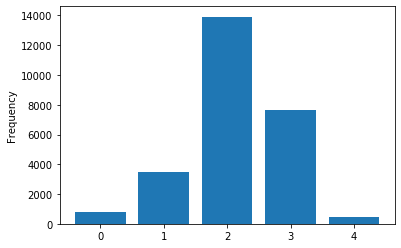

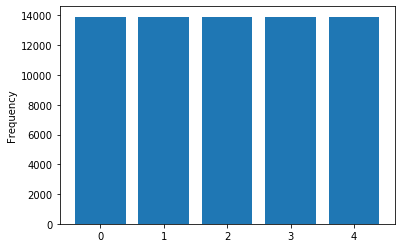

In [32]:
# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# separate features and target variable
rating = df_movies['Rating_Label'] # weight
features = df_movies.drop(columns=['Rating_Label'])

# encode labels
lab_enc = LabelEncoder()
rating = lab_enc.fit_transform(rating)
features["director"] = features["director"].astype(str)
features["director"] = lab_enc.fit_transform(features["director"])

# create a train/test split
features_train, features_test, rating_train, rating_test = train_test_split(features, rating, test_size=0.4, random_state=42, stratify=rating )

print("Train: " + str(len(features_train)) + " Features and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features and " + str(len(rating_test)) + " Ratings")

class_dist = pd.Series(rating_train).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

# from imblearn.under_sampling import RandomUnderSampler

# sampler = RandomUnderSampler()
# features_balanced_train, rating_balanced_train = sampler.fit_resample(features_train, rating_train)

# class_dist = pd.Series(rating_balanced_train).value_counts()
# plt.bar(class_dist.index, class_dist)
# plt.ylabel("Frequency")
# plt.show()


from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler()
features_balanced_train, rating_balanced_train = sampler.fit_resample(features_train, rating_train)

class_dist = pd.Series(rating_balanced_train).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

features_train = features_balanced_train
rating_train = rating_balanced_train

# Initial evaluation of different classifiers

In [33]:
##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

print("Scores Random Forest:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_rf)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_rf)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_rf, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_rf, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_rf, average='weighted')))
print()

##### create and fit a KNN
knn_reg = KNeighborsClassifier()
knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")
# #compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_knn)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_knn)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_knn, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_knn, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_knn, average='weighted')))
print()

##### create and fit a DecisionTreeClassifier
dt_reg = DecisionTreeClassifier()
dt_reg.fit(features_train, rating_train)
rating_pred_dt = dt_reg.predict(features_test)

print("Scores Decision Tree:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_dt)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_dt)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_dt, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_dt, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_dt, average='weighted')))
print()

##### create and fit a GaussianNB
nb_reg = GaussianNB()
nb_reg.fit(features_train, rating_train)
rating_pred_nb = nb_reg.predict(features_test)

print("Scores Naive Bayes:")
# #compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_nb)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_nb)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_nb, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_nb, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_nb, average='weighted')))
print()

##### create and fit a SVC
svc_reg = LinearSVC()
svc_reg.fit(features_train, rating_train)
rating_pred_svc = svc_reg.predict(features_test)

print("Scores SVC:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_svc)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_svc)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_svc, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_svc, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_svc, average='weighted')))
print()

#plot the confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=lab_enc.classes_, title='KNN Classifier')

print()

# metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))



C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores Random Forest:
Accuracy: 0.42196136531996126
Precision: 0.423862983762869
Recall: 0.42196136531996126
f1_score: 0.42260909847122813

Scores knn:
Accuracy: 0.30092882785343894
Precision: 0.39013129698635296
Recall: 0.30092882785343894
f1_score: 0.3292925953271871

Scores Decision Tree:
Accuracy: 0.39643284517636335
Precision: 0.40967333014027124
Recall: 0.39643284517636335
f1_score: 0.4027136325977395

Scores Naive Bayes:
Accuracy: 0.05920565274374608
Precision: 0.41439640377961157
Recall: 0.05920565274374608
f1_score: 0.07522468115585328

Scores SVC:
Accuracy: 0.38805629950424525
Precision: 0.42826088856197886
Recall: 0.38805629950424525
f1_score: 0.33955250772365897




C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## It seems that KNN & Random Forrest are the best classifiers. With those two we will now do some parameter tuning...

We will see with wich k the algorithm works best:

In [34]:
# create and fit a knn classifier
knn_reg = KNeighborsClassifier()

knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")

# specify the parameter grid
parameters = {
    'n_neighbors': range(2, 30)
}


# create the grid search instance
grid_search_estimator = GridSearchCV(knn_reg, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(features_train, rating_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Scores knn:
best score is 0.7760241483398016 with params {'n_neighbors': 2}


In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Scores knn:
Fold 0: Accuracy = 53.979885057471265%
Fold 1: Accuracy = 54.468390804597696%
Fold 2: Accuracy = 54.037356321839084%
Fold 3: Accuracy = 53.44827586206896%
Fold 4: Accuracy = 54.30625449317038%
Fold 5: Accuracy = 54.36376707404745%
Fold 6: Accuracy = 53.74550682961898%
Fold 7: Accuracy = 54.14809489575845%
Fold 8: Accuracy = 54.953271028037385%
Fold 9: Accuracy = 54.76635514018692%
Average Accuracy = 54.221715750679664%

Accuracy on Test Data: 0.20696335973559746
f1_score on Test Data: 0.25406681921076113
Confusion matrix, without normalization
[[  33  123  265  105   10]
 [ 108  526 1197  433   35]
 [ 254 1362 5118 2404  139]
 [ 123  581 2629 1682  102]
 [  16   43  168   83   10]]


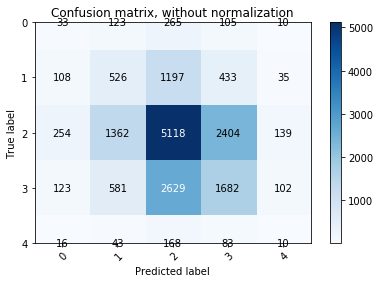

In [39]:
# do now Knn with k = 29 and applie 10 cross fold

# create and fit a knn classifier
knn_reg = KNeighborsClassifier(n_neighbors=29)

knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")


#compute accuracy score

accuracy_knn = cross_val_score(knn_reg, features_train, rating_train, cv=stratified_10_fold_cv, scoring='accuracy')

for i, acc in enumerate(accuracy_knn):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_knn.mean() * 100.0))
print()
print("Accuracy on Test Data: {}".format(accuracy_score(rating_test, rating_pred_knn)))
print("f1_score on Test Data: {}".format(f1_score(rating_test, rating_pred_knn, average='weighted')))

class_names = ['0','1','2','3','4','5']


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(rating_test, rating_pred_rf, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


Tuning of Random forrest:

In [40]:
##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

#Tuning of algorithm

# specify the parameter grid
parameters = {
    'max_depth':[3,5,10,None],
     'criterion':["gini", "entropy"],
     'max_features':["auto","log2",None]
}


# create the grid search instance
grid_search_estimator = GridSearchCV(rf_reg, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(features_train, rating_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))




print()


C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


best score is 0.8526232571510709 with params {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto'}



C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores Random Forrest:
Fold 0: Accuracy = 29.080459770114942%
Fold 1: Accuracy = 30.660919540229887%
Fold 2: Accuracy = 30.1867816091954%
Fold 3: Accuracy = 29.03735632183908%
Fold 4: Accuracy = 29.1588785046729%
Fold 5: Accuracy = 29.05823148813803%
Fold 6: Accuracy = 29.259525521207763%
Fold 7: Accuracy = 28.986340762041696%
Fold 8: Accuracy = 29.245147375988495%
Fold 9: Accuracy = 29.6764917325665%
Average Accuracy = 29.435013262599476%

Accuracy on Test Data: 0.20929967519516782
f1_score on Test Data: 0.15730682169059448
Confusion matrix, without normalization
[[  88   39    0  129  280]
 [ 345  205    0  635 1114]
 [ 532  430    0 4579 3736]
 [  87   82    0 3209 1739]
 [   7    2    0  140  171]]


C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


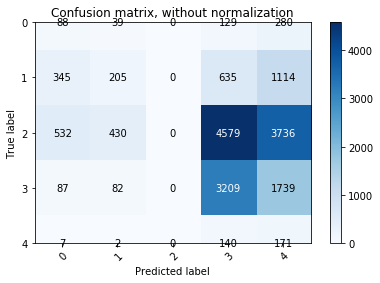

In [41]:
# do now Random Forest with entropy, maxdeepth 3 and applie 10 cross fold

##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier(criterion='gini', max_depth=3, max_features=None)
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

print("Scores Random Forrest:")


#compute accuracy score

accuracy_knn = cross_val_score(rf_reg, features_train, rating_train, cv=stratified_10_fold_cv, scoring='accuracy')

for i, acc in enumerate(accuracy_knn):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_knn.mean() * 100.0))
print()
print("Accuracy on Test Data: {}".format(accuracy_score(rating_test, rating_pred_rf)))
print("f1_score on Test Data: {}".format(f1_score(rating_test, rating_pred_rf, average='weighted')))

class_names = ['0','1','2','3','4','5']


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(rating_test, rating_pred_rf, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


## Analysis of Modell with Cluster Data

In [46]:
#Load the data

df_movies_cluster = pd.read_csv("classificationPreprocessingWithClustering.csv")
print("Length after import: " + str(len(df_movies)))
df_movies_cluster = df_movies_cluster.fillna(0)
print(df_movies_cluster.head(5))
df_movies_cluster.columns

Length after import: 43872
   usercluster  movieId    budget   id  runtime  Documentary  Foreign  Action  \
0            0        1  30000000  862     81.0          0.0      0.0     0.0   
1            1        1  30000000  862     81.0          0.0      0.0     0.0   
2            2        1  30000000  862     81.0          0.0      0.0     0.0   
3            3        1  30000000  862     81.0          0.0      0.0     0.0   
4            4        1  30000000  862     81.0          0.0      0.0     0.0   

   Horror  War  ...  actor_Donald Sutherland  actor_Robert De Niro  \
0     0.0  0.0  ...                        0                     0   
1     0.0  0.0  ...                        0                     0   
2     0.0  0.0  ...                        0                     0   
3     0.0  0.0  ...                        0                     0   
4     0.0  0.0  ...                        0                     0   

   actor_Samuel L. Jackson  actor_Jackie Chan  actor_Michael Cain

Index(['usercluster', 'movieId', 'budget', 'id', 'runtime', 'Documentary',
       'Foreign', 'Action', 'Horror', 'War', 'Romance', 'Adventure',
       'Thriller', 'History', 'Drama', 'Family', 'Comedy', 'TV Movie', 'Crime',
       'Western', 'Mystery', 'Fantasy', 'Animation', 'Music',
       'Science Fiction', 'part_of_collection', '+18', 'hasHomepage', '18+',
       'spokenLanguages', 'imdbId', 'rating_y', 'director', 'actors',
       'pcomp_Orion Pictures', 'pcomp_New Line Cinema', 'pcomp_Gaumont',
       'pcomp_Twentieth Century Fox Film Corporation',
       'pcomp_Walt Disney Productions', 'pcomp_Paramount Pictures',
       'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
       'pcomp_StudioCanal', 'pcomp_Columbia Pictures Corporation',
       'pcomp_Regency Enterprises', 'pcomp_Touchstone Pictures',
       'pcomp_Mosfilm', 'pcomp_RKO Radio Pictures', 'pcomp_Miramax Films',
       'pcomp_TriStar Pictures', 'pcomp_Columbia Pictures',
       'pcomp_Toho Company', 'pcom

The Data set is similair, we just have and additional column usercluster. In order to have comparable results we remove the same columns as in the previous set:

In [47]:
# drop columns that are not needed maybe implement feature selction...



features_to_remove = ['actors', 'movieId', 'imdbId', 'id', '+18','spokenLanguages', 'rating_y'
                     ]
for i in features_to_remove:
    if i in df_movies_cluster.columns:
        df_movies_cluster = df_movies_cluster.drop(columns=i)
print(len(df_movies_cluster))
print(df_movies_cluster.usercluster.unique())
df_movies_cluster.columns



118856
[0 1 2 3 4 5 6 7 8]


Index(['usercluster', 'budget', 'runtime', 'Documentary', 'Foreign', 'Action',
       'Horror', 'War', 'Romance', 'Adventure', 'Thriller', 'History', 'Drama',
       'Family', 'Comedy', 'TV Movie', 'Crime', 'Western', 'Mystery',
       'Fantasy', 'Animation', 'Music', 'Science Fiction',
       'part_of_collection', 'hasHomepage', '18+', 'director',
       'pcomp_Orion Pictures', 'pcomp_New Line Cinema', 'pcomp_Gaumont',
       'pcomp_Twentieth Century Fox Film Corporation',
       'pcomp_Walt Disney Productions', 'pcomp_Paramount Pictures',
       'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
       'pcomp_StudioCanal', 'pcomp_Columbia Pictures Corporation',
       'pcomp_Regency Enterprises', 'pcomp_Touchstone Pictures',
       'pcomp_Mosfilm', 'pcomp_RKO Radio Pictures', 'pcomp_Miramax Films',
       'pcomp_TriStar Pictures', 'pcomp_Columbia Pictures',
       'pcomp_Toho Company', 'pcomp_Relativity Media',
       'pcomp_Walt Disney Pictures', 'pcomp_BBC Films', 'pcom

We create again a startified training and test data, as well as we split the target from the feature:

Train: 71313 Features and 71313 Ratings
Test: 47543 Features and 47543 Ratings


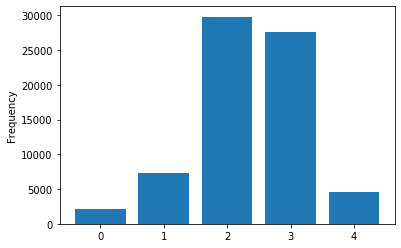

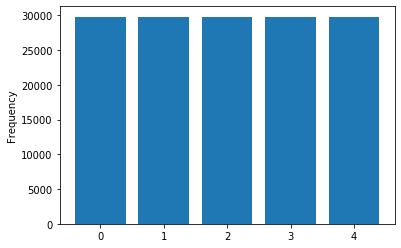

In [48]:
# separate features and target variable
rating = df_movies_cluster['Rating_Label'] # weight
features = df_movies_cluster.drop(columns=['Rating_Label'])

# encode labels
lab_enc = LabelEncoder()
rating = lab_enc.fit_transform(rating)
features["director"] = features["director"].astype(str)
features["director"] = lab_enc.fit_transform(features["director"])

# create a train/test split
features_train, features_test, rating_train, rating_test = train_test_split(features, rating, test_size=0.4, random_state=42, stratify=rating )

print("Train: " + str(len(features_train)) + " Features and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features and " + str(len(rating_test)) + " Ratings")

class_dist = pd.Series(rating_train).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

# from imblearn.under_sampling import RandomUnderSampler

# sampler = RandomUnderSampler()
# features_balanced_train, rating_balanced_train = sampler.fit_resample(features_train, rating_train)

# class_dist = pd.Series(rating_balanced_train).value_counts()
# plt.bar(class_dist.index, class_dist)
# plt.ylabel("Frequency")
# plt.show()


from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler()
features_balanced_train, rating_balanced_train = sampler.fit_resample(features_train, rating_train)

class_dist = pd.Series(rating_balanced_train).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

features_train = features_balanced_train
rating_train = rating_balanced_train

Now we do the initial evaluation on all the classifiers again, to see wether there is a difference

In [49]:
##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

print("Scores Random Forest:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_rf)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_rf)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_rf, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_rf, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_rf, average='weighted')))
print()

##### create and fit a KNN
knn_reg = KNeighborsClassifier()
knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")
# #compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_knn)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_knn)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_knn, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_knn, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_knn, average='weighted')))
print()

##### create and fit a DecisionTreeClassifier
dt_reg = DecisionTreeClassifier()
dt_reg.fit(features_train, rating_train)
rating_pred_dt = dt_reg.predict(features_test)

print("Scores Decision Tree:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_dt)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_dt)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_dt, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_dt, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_dt, average='weighted')))
print()

##### create and fit a GaussianNB
nb_reg = GaussianNB()
nb_reg.fit(features_train, rating_train)
rating_pred_nb = nb_reg.predict(features_test)

print("Scores Naive Bayes:")
# #compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_nb)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_nb)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_nb, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_nb, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_nb, average='weighted')))
print()

##### create and fit a SVC
svc_reg = LinearSVC()
svc_reg.fit(features_train, rating_train)
rating_pred_svc = svc_reg.predict(features_test)

print("Scores SVC:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_svc)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_svc)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_svc, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_svc, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_svc, average='weighted')))
print()

#plot the confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=lab_enc.classes_, title='KNN Classifier')

print()

# metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))



C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores Random Forest:
Accuracy: 0.47887175819784195
Precision: 0.47862274514716835
Recall: 0.47887175819784195
f1_score: 0.47827849047673837

Scores knn:
Accuracy: 0.4023515554340281
Precision: 0.48920182932753076
Recall: 0.4023515554340281
f1_score: 0.4323128024619856

Scores Decision Tree:
Accuracy: 0.4431356876932461
Precision: 0.4471697540492239
Recall: 0.4431356876932461
f1_score: 0.44507064060489815

Scores Naive Bayes:
Accuracy: 0.07018909197989188
Precision: 0.36761273263846006
Recall: 0.07018909197989188
f1_score: 0.07369242993848471

Scores SVC:
Accuracy: 0.1383799928485792
Precision: 0.35663098667677545
Recall: 0.1383799928485792
f1_score: 0.10211920697697123




C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


First evaluation:
We can see that the following algortihms got an improvement of accuracy:
- Random forrest
- KNN
- Decision Tree

The following are now worse:
- Naive Bayes
- SVC

We will analyze now KNN and random Forrest again to see if we can tune the models

In [50]:
# create and fit a knn classifier
knn_reg = KNeighborsClassifier()

knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")

# specify the parameter grid
parameters = {
    'n_neighbors': range(2, 30)
}


# create the grid search instance
grid_search_estimator = GridSearchCV(knn_reg, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(features_train, rating_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Scores knn:
best score is 0.7945327698396727 with params {'n_neighbors': 2}


Scores knn optimized:
Fold 0: Accuracy = 73.56136820925553%
Fold 1: Accuracy = 73.25285043594903%
Fold 2: Accuracy = 73.21260898725687%
Fold 3: Accuracy = 72.76324614352784%
Fold 4: Accuracy = 72.9419657832942%
Fold 5: Accuracy = 73.52566252935256%
Fold 6: Accuracy = 74.00872190540088%
Fold 7: Accuracy = 73.45186179134518%
Fold 8: Accuracy = 73.68668232136866%
Fold 9: Accuracy = 73.72022811137202%
Average Accuracy = 73.4125196218123%

Accuracy on Test Data: 0.4023515554340281
f1_score on Test Data: 0.4323128024619856
[0 1 2 3 4]
Confusion matrix, without normalization
[[  102   348   556   341    85]
 [  263  1406  2132   882   166]
 [  533  2460 11188  4982   713]
 [  350  1180  5915  9725  1193]
 [   92   221   900  1464   346]]


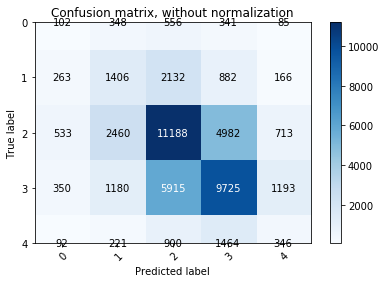

In [51]:
# do now Knn with k = 5 and applie 10 cross fold

# create and fit a knn classifier
knn_reg = KNeighborsClassifier(n_neighbors=5)

knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn optimized:")

#compute accuracy score

accuracy_knn = cross_val_score(knn_reg, features_train, rating_train, cv=stratified_10_fold_cv, scoring='accuracy')

for i, acc in enumerate(accuracy_knn):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_knn.mean() * 100.0))
print()
print("Accuracy on Test Data: {}".format(accuracy_score(rating_test, rating_pred_knn)))
print("f1_score on Test Data: {}".format(f1_score(rating_test, rating_pred_knn, average='weighted')))

class_names = ['0','1','2','3','4','5']

print(np.unique(ar=rating_train))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(rating_test, rating_pred_rf, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


In [52]:
##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

#Tuning of algorithm

# specify the parameter grid
parameters = {
    'max_depth':[3,5,10,None],
     'criterion':["gini", "entropy"],
     'max_features':["auto","log2",None]
}


# create the grid search instance
grid_search_estimator = GridSearchCV(rf_reg, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(features_train, rating_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))
print()


C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


best score is 0.8173676796136043 with params {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2'}



C:\Users\Stefan Sousa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores Random Forrest optimized:
Fold 0: Accuracy = 42.354124748490946%
Fold 1: Accuracy = 42.07914151576123%
Fold 2: Accuracy = 41.60965794768612%
Fold 3: Accuracy = 42.98457411133467%
Fold 4: Accuracy = 42.28111372022811%
Fold 5: Accuracy = 42.80442804428044%
Fold 6: Accuracy = 42.18047635021805%
Fold 7: Accuracy = 42.2609862462261%
Fold 8: Accuracy = 42.522643408252264%
Fold 9: Accuracy = 42.2609862462261%
Average Accuracy = 42.3338132338704%

Accuracy on Test Data: 0.2775382285509959
f1_score on Test Data: 0.31159571754886894
[0 1 2 3 4]
Confusion matrix, without normalization
[[ 305  427  171  109  420]
 [ 991 1780  807  329  942]
 [2475 4874 5208 2538 4781]
 [1686 2188 3105 4137 7247]
 [ 337  247  204  470 1765]]


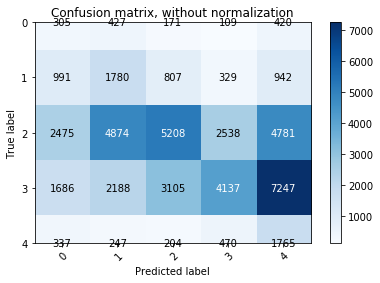

In [53]:
# do now Random Forest with gini, maxdeepth 10 and applie 10 cross fold

##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier(criterion='gini', max_depth=10, max_features=None)
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

print("Scores Random Forrest optimized:")


#compute accuracy score

accuracy_knn = cross_val_score(rf_reg, features_train, rating_train, cv=stratified_10_fold_cv, scoring='accuracy')

for i, acc in enumerate(accuracy_knn):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_knn.mean() * 100.0))
print()
print("Accuracy on Test Data: {}".format(accuracy_score(rating_test, rating_pred_rf)))
print("f1_score on Test Data: {}".format(f1_score(rating_test, rating_pred_rf, average='weighted')))

class_names = ['0','1','2','3','4','5']

print(np.unique(ar=rating_train))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(rating_test, rating_pred_rf, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()